# bpca_impute: Data Imputation with Bayesian Principal Component Analysis

**Tsuyoshi Ide**, tide@us.ibm.com, IBM Thomas J. Watson Research Center

January 1, 2022

This notebook explains `bmpca_impute`, an implementation of the data imputation method proposed in:

> Kitamoto, T., Idé, T., Tezuka, Y. et al., "Identifying primary aldosteronism patients who require adrenal venous sampling: a multi-center study," Scientific Reports 13, 21722 (2023) [[link](https://doi.org/10.1038/s41598-023-47967-z)].

There are  two importable Python modules in this `bmpca` repository. `bpca_impute` contains the core components for Bayesian Principal Component Analysis (BPCA) for unsupervised data imputation while `bpca_impute_util` contains a few utility functions for visualizations. 

- `bpca_impute`
- `bpca_impute_util`

The core module `bpca_impute`, which depends only on numpy, includes the following functions. 

- Simple model assuming an isotropic latent space
    - `em_pca`:
        - Finds principal components for data matrices with no missing entries based on the noiseless probabilistic PCA model proposed by Sam Roweis, "EM algorithms for PCA and SPCA." Advances in neural information processing systems (1998): 626-632. This function is for comparison purposes. 
    - `impute_em_pca`: 
        - Incorporates the functionality of estimating the value of missing entries into `em_pca`. The missing entries are treated as extra latent variables and are point-estimated via maximum likelihood. 
- Advanced model that can handle anisotropy over latent dimensions.
    - `impute_bpca`: 
        - Is an extension of `impute_em_pca` so that it can handle different variances for latent dimensions. The variance goes to zero if the corresponding latent dimension is considered to be irrelevant to the data; thereby the dimensionality of the latent space can be chosen automatically. In such a case, however, there is no straightforward way of computing the log-likelihood. Convergence is monitored with the projection matrix $\mathsf{W}$ and imputed values instead of the log-likelihood. 
    - `impute_bpca_ard`:
        - Uses the same anisotropic latent model as `impute_bpca`, but automatically removes irrelevant latent dimensions so the log-likelihood can be monitored. Note that there are numerically subtle issues here. The value of the likelihood may not be very accurate in some cases. If the behavior of likelihood looks weird, increase `eps`, which the observation variance. 
- Other functions
    - `impute_transfer`: 
        - Is used in the transfer learning setting, where you are to impute a test dataset based on a PCA model learned on a training dataset. 
    - `recover_components_em_pca`:
        - Recovers principal components as standard unit orthogonal vectors from $\mathsf{W}$ and $\mathbf{\mu}$. While the column space of $\mathsf{W}$ spans the principal subspace, the column vectors of it are not the same as the eigenvectors in general. 


## Background

Unsupervised data imputation approaches are roughly categorized into those based on the notion of the neighborhood and those based on low-rank representations of the data matrix. Principal component analysis (PCA) is one of the most popular data imputation methods in the second category. In fact, modern auto-encoder-based imputation approaches can be viewed as a nonlinear generalization of it, and probabilistic PCA-based approaches are often preferred to deep learning approaches for their simplicity and interpretability. PCA-based imputation methods occupy a unique position in data imputation approaches in that it systematically allows a probabilistic extension that enables the estimation of uncertainty of imputed values. 

The theoretical foundation of probabilistic PCA (PPCA)-based imputation was laid by Oba et al.(2003):

> Shigeyuki Oba, Masa-aki Sato, Ichiro Takemasa, Morito Monden, Ken-ichi Matsubara, Shin Ishii, A Bayesian missing value estimation method for gene expression profile data, Bioinformatics, Volume 19, Issue 16, 1 November 2003, Pages 2088–2096. [[link](https://academic.oup.com/bioinformatics/article/19/16/2088/242445)]

In the bioinformatics domain, their approach is known as one of the most efficient imputation methods. For a comparative study, see, e.g., [Brock et al. 2007].

> Brock, G.N., Shaffer, J.R., Blakesley, R.E. et al. Which missing value imputation method to use in expression profiles: a comparative study and two selection schemes. BMC Bioinformatics 9, 12 (2008). [[link](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-12)]

Although their method, together with their Matlab implementation, has enjoyed popularity especially in bioinformatics, it has been suggested that it may have limitations when applying to other domains. In our medical applications, we are aware the following limitations : 

1. No established way of data imputation in the **transfer learning** setting. This is particularly important in medical applications, where you often need to make a medical decision based on a relatively small test dataset.  
1. Limited consume-ability of the model. In particular, the choice of the dimensionality of the latent space is a major issue of the factorization-based imputation methods. The standard isotropic models cannot determine the dimensionality, while fully Bayesian methods often require Monte Carlo sampling or give too much information that is hard-to-digest to most of the end-users. 
1. Limited choice of Python implementation. 


## Model

Suppose that you have a diagnosis support tool $y=f(\mathbf{x})$, where $y$ can be whether to perform a surgery or whether or not a patient have a cancer. The predictor $\mathbf{x}$ is a set of attributes of a patient. To compute $y$, you will need to have *all* the attributes. But what if there are only a few missing entries? As most of the information is in place, you may think that the system should give at least some suggestion. This is exactly where a data imputation tool comes in handy. By filling in a likely value to each missing value, we can move on to the next step somehow. The question is how trustworthy the filled value would be. 

The proposed approach performs what they call the MAP (maximum a posterior) estimation for missing entries, based on a Bayesian principal component analysis model provided below. This means that the filled values is the most likely estimate given observed data under potential uncertainty. Basically, this is the best we could do. 

The proposed anisotropic latent space model employs the following generative model:
$$
p_\mathrm{obs}(\mathbf{x}\mid \mathbf{z}) = 
    \mathcal{N}(\mathbf{x} \mid \mathsf{W}\mathbf{z}+\mathbf{\mu},\epsilon \mathsf{I}_M)
$$ 
$$
p_\mathrm{prior1}(\mathbf{z}) = \mathcal{N}(\mathbf{z} \mid \mathbf{0},\mathsf{I}_d)
$$
$$
p_\mathrm{prior2}(\mathsf{W}) = \prod_{l=1}^d \mathcal{N}(\mathbf{w}_l \mid \mathbf{0}, \alpha_l  \mathsf{I}_M)
$$
Here, in general, $\mathcal{N}(\mathbf{x} \mid \mathbf{m},\mathsf{\Sigma})$ denotes the Gaussian distribution for $\mathbf{x}$ with $\mathbf{m}$ being the and $\mathsf{\Sigma}$ being the covariance matrix. 

The isotropic model, on the other hand, omits $p_\mathrm{prior2}(\mathsf{W})$ and does not learn $\{\alpha_l\}$. 

The dimensionality of the variables and the model parameters are defined as:

- Observed variable: $\mathbf{x} \in \mathbb{R}^M$
- Latent variable: $\mathbf{z} \in \mathbb{R}^d$ and missing entries in $\mathbf{x}$
- Projection matrix, whose column space spans the principal subspace: $\mathsf{W}=[\mathbf{w}_1, \ldots, \mathbf{w}_d] \in \mathbb{R}^{M\times d}$

In the limit of $\epsilon\rightarrow 0$, the above model provides an interesting and useful compromise of the fully probabilistic model. The posterior distribution for $\mathsf{W},\mathbf{z}$ becomes Dirac's delta function and thus Bayesian inference is more like point estimation. In addition, by point-estimating $\{\alpha_l\}$ by maximizing the log likelihood, one can automatically determine the dimensionality of the latent space. This is one realization of automatic relevance determination (ARD) in Bayesian learning. For general information, see  C. Bishop, "Pattern Recognition and Machine Learning," Springer, Chap.12.



## Demo 1: Data Imputation of single dataset


### Algorithm

Suppose that we are given a dataset $\mathcal{D}_{\mathrm{train}}\triangleq \{\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)} \}$, where some of the samples $\{ \mathbf{x}^{(n)}\}$ contain missing entries. The model parameters of the anisotropic model are learned as follows.

- Initialization: $\mathbf{\mu}$ and missing entries are set to the sample mean. $\mathsf{W}$ is initialized via QR factorization of the data matrix (see the code).
- Repeat until convergence:
    - $\mathsf{Z} \leftarrow [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1} \mathsf{W}^\top \mathsf{\Phi}$
    - $\mathsf{W} \leftarrow \mathsf{\Phi} \mathsf{Z}^\top \mathsf{A} [\epsilon\mathsf{I}_d + \mathsf{Z}\mathsf{Z}^\top \mathsf{A}]^{-1} $
    - $\mathbf{\mu} \leftarrow \frac{1}{N}(\mathsf{X} - \mathsf{W}\mathsf{Z}) \mathbf{1}_N$
    - $ \alpha_i = \frac{1}{M} \|\mathbf{w}_i \|^2$ for $i=1,\ldots,d$
    - $x^{(n)}_j = [\mathsf{W} \mathbf{z}^{(n)}+\mathbf{\mu}]_j \quad (\mathrm{missing \ entries})$
- Output: $\mathsf{X}, \mathsf{W}, \mathsf{Z}, \mathsf{A}, \mathbf{\mu}$

Here, 
- $\mathsf{X}\triangleq [\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)}]$ 
- $\mathsf{Z}\triangleq [\mathbf{z}^{(1)},\ldots,\mathbf{z}^{(N)}]$
- $\mathsf{\Phi} \triangleq [\mathbf{x}^{(1)}-\mathbf{\mu}, \ldots, \mathbf{x}^{(N)}-\mathbf{\mu}]$
- $\mathsf{A} = \mathrm{diag}(\alpha_1, \ldots, \alpha_d)$ 


### Dataset

We use basically the same data set as the one used in [Kitamoto et al. 22]. To protect patients' privacy, we removed personal attributes from the data, anonymized the variable names, and randomized the value and order of the patients/variables while keeping certain statistical properties.

In the below, `df_tr` is a pandas DataFrame, where each row corresponds to one patient. The last eight variables were created via one-hot encoding of two categorical variables. There a many missing entries in the data. The function `show_missing_pattern_binary()` helps visualize the missing pattern.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import pandas as pd
df_tr = pd.read_csv( './data/Xtr.csv')
df_tr

Wall time: 567 ms


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x26,x27,x29_A,x29_B,x29_C,x29_D,x30_A,x30_B,x30_C,x30_D
0,0.448229,-0.649316,0.817186,0.460971,-0.067882,1.825301,-1.427961,0.846719,-0.758353,0.288376,...,-0.361824,0.515343,-0.636500,0.626428,-0.270361,-0.801655,1.657359,-0.707739,-0.084972,-0.801655
1,0.512760,0.063060,0.288533,0.063483,-1.119464,-0.545884,0.395598,1.029512,0.956802,-0.056576,...,-0.361824,-0.111082,0.931137,-0.203804,-0.270361,-0.801655,-0.601199,1.407868,-0.084972,-0.801655
2,-0.583018,0.535236,0.661652,0.589891,0.913594,-0.545884,-0.413345,0.452810,-0.758353,-0.943033,...,-0.777435,-0.688691,0.931137,-0.813177,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
3,-1.241035,-1.605883,0.234015,-1.147130,-0.768937,-0.545884,-0.710092,-0.949770,-0.758353,-0.137068,...,-0.777435,-0.594410,1.127092,-0.149986,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
4,-0.366251,-0.011533,-1.435082,0.654154,-0.278198,-0.545884,-0.115195,-0.538204,-0.758353,-0.261169,...,0.831299,-0.018276,0.147318,-0.097419,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,-0.256864,-0.621154,0.179183,0.989963,0.212540,1.825301,-0.830609,0.767022,-0.758353,-0.144652,...,-0.361824,0.541403,-1.028410,0.643746,-0.270361,-0.801655,1.657359,-0.707739,-0.084972,-0.801655
274,1.058621,0.512598,-1.632597,-0.951289,0.142434,-0.545884,0.152579,1.605883,1.181367,0.488724,...,-0.777435,0.504804,-0.440546,0.236496,-0.270361,-0.801655,-0.601199,1.407868,-0.084972,-0.801655
275,-0.366251,-1.029700,-0.156615,-0.362709,0.282645,-0.545884,0.733970,1.349523,0.323790,0.562782,...,-0.777435,0.214032,-0.636500,0.446870,3.685450,-0.801655,-0.601199,-0.707739,11.726193,-0.801655
276,NaN,NaN,0.234015,0.272060,-0.839042,-0.545884,NaN,NaN,-0.758353,NaN,...,NaN,NaN,-0.636500,NaN,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933


Wall time: 1.41 s


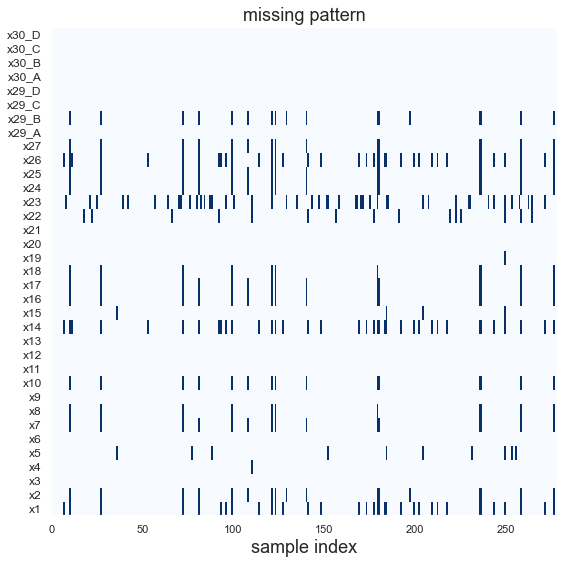

In [3]:
%%time
import bpca_impute.bpca_impute_util as util
_,_ = util.show_missing_pattern_binary(df_tr,figsize=(8,8))

### Performing data imputation

In this demo, we first use `impute_bpca()` for imputation. The only non-optional input is a data matrix as a 2D Numpy array, where the columns correspond to the samples. The function returns an imputed data matrix `X_filled` and a dictionary of the model parameters:

- `W`: projection matrix.
- `Z`: $[\mathbf{z}^{(1)}, \ldots, \mathbf{z}^{(N)}]$
- `Adiag`: $[\alpha_1, \ldots, \alpha_d]$
- `err_X`: Root mean square error of the missing entries, compared to that of the previous iteration round. Let $\mathbf{g}$ a vector of the values of the missing entries. Then, this quantity stores the following quantity in each iteration round:
    $$
    \mathrm{err\_X} = \frac{\|\mathbf{g} -\mathbf{g}_{\mathrm{previous}} \|}{\|\mathbf{g}\|}
    $$
- `err_W`: The same as above with $\mathbf{g}$ being the flattened version of $\mathsf{W}$.

In [4]:
%%time
import bpca_impute.bpca_impute as bi
X = df_tr.to_numpy().T
X_filled, param = bi.impute_bpca(X)

W = param.get('W')
Z = param.get('Z')
Adiag = param.get('Adiag')
mu = param.get('mu')
err_x = param.get('err_x')
err_W = param.get('err_W')

#samples=278, obs.dim=35, latent dim=34
  50: err_W=0.00030, err_x=0.02204
 100: err_W=0.00024, err_x=0.01065
 150: err_W=0.00021, err_x=0.00678
 200: err_W=0.00019, err_x=0.00486
 250: err_W=0.00017, err_x=0.00372
 300: err_W=0.00016, err_x=0.00297
 350: err_W=0.00015, err_x=0.00245
 400: err_W=0.00014, err_x=0.00206
 450: err_W=0.00014, err_x=0.00176
 500: err_W=0.00013, err_x=0.00152
Finished: itr=500, err_W=0.00013196352930219829, err_x=0.0015244658684773413
Wall time: 1.24 s


You can visualize `err_X, err_W` as a function of the iteration count to check the convergence behaviors as below.

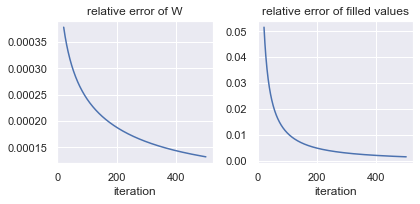

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import numpy as np
fig,ax = plt.subplots(1,2,figsize=(6,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(err_x)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],err_W[itr0:]) 
ax[0].set_title('relative error of W')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_x[itr0:]) 
ax[1].set_title('relative error of filled values')
ax[1].set_xlabel('iteration')    
fig.tight_layout()


### Manually removing irrelevant latent dimensions

In the below, we plot a bar chart for `Adiag`. We see that a few dimensions are very close to zero and thus redundant. If you want to explicitly remove those dimensions, use `shrink_latent_space()`:

Text(0, 0.5, 'variance of latent dimension')

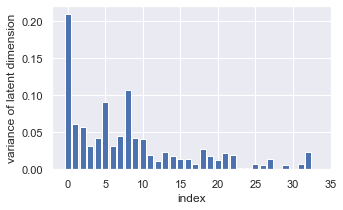

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(len(Adiag)),Adiag)
ax.set_xlabel('index')
ax.set_ylabel('variance of latent dimension')

Text(0, 0.5, 'variance of latent dimension')

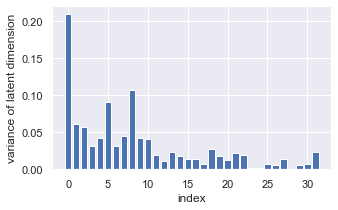

In [7]:
W,Adiag,Z = bi.shrink_latent_space(W,Adiag,Z)

fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(len(Adiag)),Adiag)
ax.set_xlabel('index')
ax.set_ylabel('variance of latent dimension')

### Automatically removing irrelevant latent dimensions

`impute_bpca_ard()` allows automatically removing irrelevant latent dimensions. In this case, it reduced the dimension from 34 to 32, as indicated by the following message.
```
itr=0:latent space got shrunk from 34 to 32
```


In [8]:
%%time
X = df_tr.to_numpy().T
X_filled, param = bi.impute_bpca_ard(X)
W = param.get('W')
Z = param.get('Z')
Adiag = param.get('Adiag')
mu = param.get('mu')
err_x = param.get('err_x')
err_W = param.get('err_W')

#samples=278, obs.dim=35, initial latent dim=34
	itr=0:latent space got shrunk from 34 to 32
  50: err_L=0.00020, err_x=0.02204
 100: err_L=0.00012, err_x=0.01065
 150: err_L=0.00009, err_x=0.00678
 200: err_L=0.00007, err_x=0.00486
 250: err_L=0.00006, err_x=0.00372
 300: err_L=0.00005, err_x=0.00297
 350: err_L=0.00005, err_x=0.00245
 400: err_L=0.00004, err_x=0.00206
 450: err_L=0.00004, err_x=0.00176
 500: err_L=0.00003, err_x=0.00152
Finished ARD_BPCA:itr=500, err_L=3.440501484637637e-05, err_x=0.0015244658684691109
Wall time: 702 ms


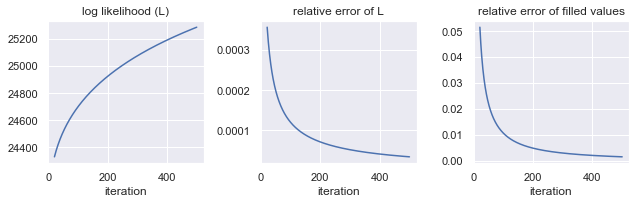

In [9]:
W = param.get('W')
Adiag = param.get('Adiag')
mu = param.get('mu')
loglik = param.get('loglik')
err_x = param.get('err_x')
err_L = param.get('err_L')

fig,ax = plt.subplots(1,3,figsize=(9,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(loglik)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],loglik[itr0:])
ax[0].set_title('log likelihood (L)')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_L[itr0:]) 
ax[1].set_title('relative error of L')
ax[1].set_xlabel('iteration')
ax[2].plot(itr_sequence[itr0:],err_x[itr0:]) 
ax[2].set_title('relative error of filled values')
ax[2].set_xlabel('iteration')    
fig.tight_layout()
    

### Comparing with mean imputation 

We visually compare this approach with the naive mean-imputation approach. As shown, PPCA-based method seems to produce a smoother pattern. 

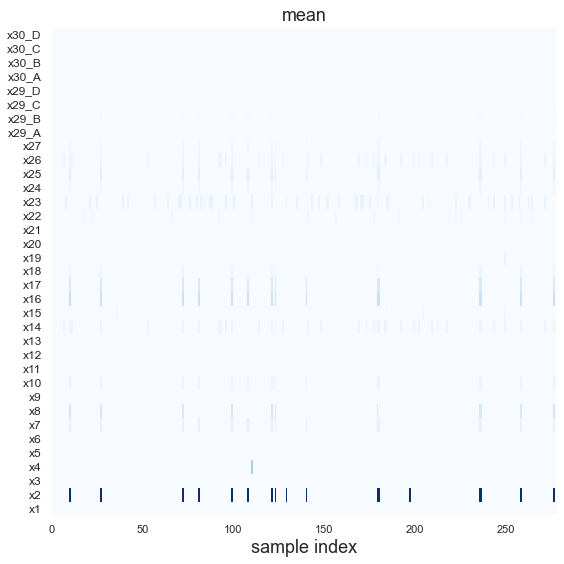

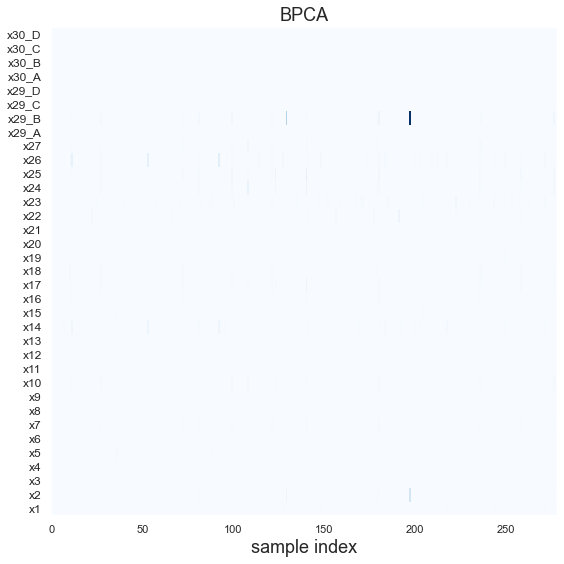

In [10]:
import bpca_impute.bpca_impute_util as util
mask = df_tr.isna()

df_mean_filled = df_tr.fillna(df_tr.mean(axis=0))    
_,_=util.show_missing_pattern(df_mean_filled, mask, title_string='mean',figsize=(8,8)) 

df_filled = pd.DataFrame(X_filled.T,columns=df_tr.columns)
_,_=util.show_missing_pattern(df_filled, mask, title_string='BPCA',figsize=(8,8)) 



## Demo 2: Transfer learning from training dataset, I

The problem setting we wish to address here is summarized as follows.

- We are given two datasets $\mathcal{D}_{\mathrm{train}}$ and $\mathcal{D}_{\mathrm{test}}$, where the former is typically much larger than the latter. 
- Both $\mathcal{D}_{\mathrm{train}}$ and $\mathcal{D}_{\mathrm{test}}$ may have missing entries. 
- We do not have access to $\mathcal{D}_{\mathrm{train}}$ but we do have access to the model parameter trained on $\mathcal{D}_{\mathrm{train}}$: $\{ \mathsf{W, A}, \mathbf{\mu}\}$
- **We wish to fill in missing entries of $\mathcal{D}_{\mathrm{test}}$ with the aid of $\mathcal{D}_{\mathrm{train}}$'s imputation model.**

This is a very realistic problem in the medical domain. You almost alway want to leverage a large cohort from major medical institutions for your diagnoses but you typically do not have access to the data. Also, there is no established imputation approach of "transferring" the models trained on a different dataset. 



### Loading another dataset 

Now we load another data set and put it into a DataFrame named `df_te`. We see that it has a quite different missing pattern from `df_tr`.

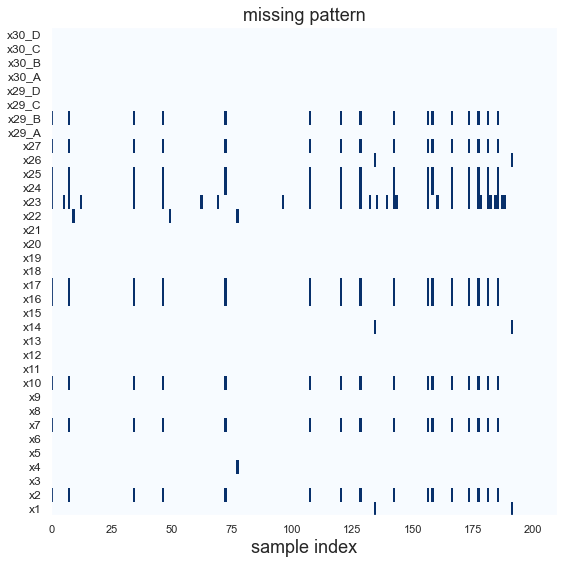

In [11]:
df_te = pd.read_csv( './data/Xte.csv')
_,_ = util.show_missing_pattern_binary(df_te,figsize=(8,8))

### Algorithm

Here we propose two scenarios: 

#### (1) Reuse both $\mathbf{\mu}$ and $\mathsf{W}$, assuming that $\mathcal{D}_{\mathrm{train}}$ and $\mathcal{D}_{\mathrm{test}}$ are well calibrated. 

Let the data matrix of $\mathcal{D}_\mathrm{test}$ be 
$$
\mathsf{X}_\mathrm{te} \triangleq [\mathbf{x}^{[1]}, \ldots, \mathbf{x}^{[N_\mathrm{te}]}].
$$

We run the following iterative algorithm on $\mathcal{D}_{\mathrm{test}}$. 
- Initialization:  $x_j = \mu_j$ for missing entries.
- Iteration until convergence ($n=1,\ldots,N_\mathrm{te}$):
    - $\mathbf{z}^{[n]} = [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1}\mathsf{W}^\top (\mathbf{x}^{[n]} - \mathbf{\mu})$ 
    - $x_j^{[n]} \leftarrow [\mathsf{W} \mathbf{z}^{[n]}+\mathbf{\mu}]_j$ (missing entries)

#### (2) Reuse only  $\mathsf{W}$

In this case, we run the following. 

- Initialization: $x_j = \mu_j$ for missing entries.
- Iteration until convergence ($n=1,\ldots,N_\mathrm{te}$ )
    - $\mathbf{z}^{[n]} = [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1}\mathsf{W}^\top (\mathbf{x}^{[n]} - \mathbf{\mu}_\mathrm{te})$ 
    - $\mathbf{\mu}_\mathrm{te} \leftarrow \frac{1}{N}(\mathsf{X}_\mathrm{te} - \mathsf{W}\mathsf{Z}_\mathrm{te}) \mathbf{1}_{N_\mathrm{te}}$
    - $x_j^{[n]} \leftarrow [\mathsf{W} \mathbf{z}^{[n]}+\mathbf{\mu}_\mathrm{te}]_j$ (missing entries)

### Performing imputation of `df_tr`

In [12]:
import bpca_impute.bpca_impute as bi
_,param = bi.impute_bpca_ard(df_tr.to_numpy().T)

W = param.get('W')
Adiag = param.get('Adiag')
mu = param.get('mu')


#samples=278, obs.dim=35, initial latent dim=34
	itr=0:latent space got shrunk from 34 to 32
  50: err_L=0.00020, err_x=0.02204
 100: err_L=0.00012, err_x=0.01065
 150: err_L=0.00009, err_x=0.00678
 200: err_L=0.00007, err_x=0.00486
 250: err_L=0.00006, err_x=0.00372
 300: err_L=0.00005, err_x=0.00297
 350: err_L=0.00005, err_x=0.00245
 400: err_L=0.00004, err_x=0.00206
 450: err_L=0.00004, err_x=0.00176
 500: err_L=0.00003, err_x=0.00152
Finished ARD_BPCA:itr=500, err_L=3.440501484637637e-05, err_x=0.0015244658684691109


### Performing transfer imputation for `df_te`

In [13]:
Xte_imputed, param2 =\
    bi.impute_transfer(df_te.to_numpy().T, W, mu=None,
                                eps=1.e-3, itr_max=1000, 
                                err_L_th=1.e-4,err_x_th=1.e-4)
loglik_test = param2.get('loglik')
err_L_test = param2.get('err_L')
err_x_test = param2.get('err_x')
Z_test = param2.get('Z')

 100: err_L=0.00001, err_x=0.00883
 200: err_L=0.00001, err_x=0.00418
 300: err_L=0.00000, err_x=0.00265
 400: err_L=0.00000, err_x=0.00189
 500: err_L=0.00000, err_x=0.00145
 600: err_L=0.00000, err_x=0.00116
 700: err_L=0.00000, err_x=0.00095
 800: err_L=0.00000, err_x=0.00080
 900: err_L=0.00000, err_x=0.00068
1000: err_L=0.00000, err_x=0.00059
Finished EM_PCA transfer itr=1000,err_L=1.0210275529407966e-06,err_x=0.0005887767699171928


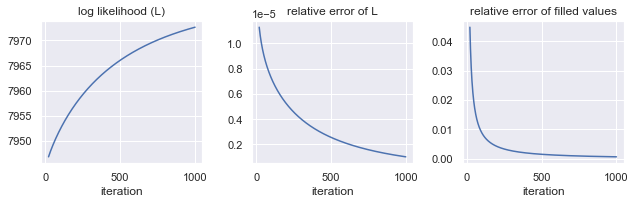

In [14]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
fig,ax = plt.subplots(1,3,figsize=(9,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(loglik_test)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],loglik_test[itr0:])
ax[0].set_title('log likelihood (L)')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_L_test[itr0:]) 
ax[1].set_title('relative error of L')
ax[1].set_xlabel('iteration')
ax[2].plot(itr_sequence[itr0:],err_x_test[itr0:]) 
ax[2].set_title('relative error of filled values')
ax[2].set_xlabel('iteration')    
fig.tight_layout()

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'impute_transfer'}, xlabel='sample index'>)

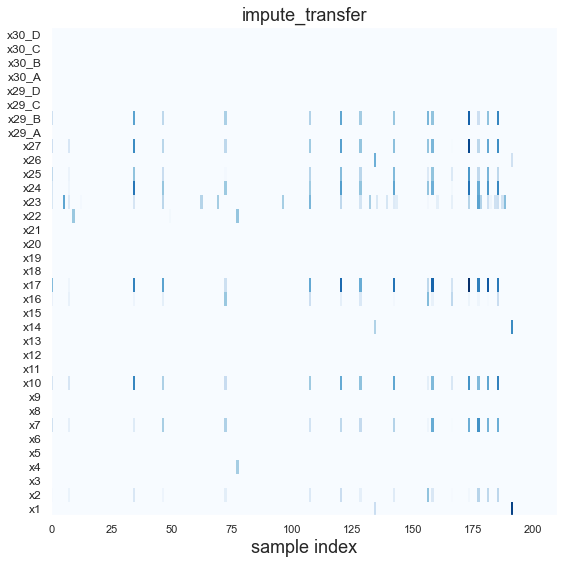

In [15]:
mask = df_te.isna()
df_filled = pd.DataFrame(Xte_imputed.T,columns=df_te.columns)
util.show_missing_pattern(df_filled,mask, title_string='impute_transfer') 


## Demo 3: Transfer learning from training dataset, II

In this demo, we use another dataset `cancer_reg.csv`, which has been copied in `./data/` subfolder (we thank Ms. Neelima Reddy Gade for reporting bugs). The dataset is more 'raw' than the previous data in that the dataset is not standardized. 

### Loading data

In [16]:
# Loading data
import pandas as pd
df_data = pd.read_csv("./data/cancer_reg.csv",encoding='latin-1')
df_data

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


### Looking at how missing entries are distributed

Let us look at how missing entires are distributed in the data. As seen below, there are $N=3047$ samples in the dataset. A variable named `PctSomeCol18_24` has 2285 missing values, which accounts for 75\% of the total samples. We should probably drop variables where the majority is missing, but let us use all the variables as-is for illustration purposes.

In the below, `show_missing_pattern_binary()` is used to visualize the missing pattern.

In [17]:
display(df_data.shape)
df_data.isna().sum()

(3047, 34)

avgAnnCount                   0
avgDeathsPerYear              0
TARGET_deathRate              0
incidenceRate                 0
medIncome                     0
popEst2015                    0
povertyPercent                0
studyPerCap                   0
binnedInc                     0
MedianAge                     0
MedianAgeMale                 0
MedianAgeFemale               0
Geography                     0
AvgHouseholdSize              0
PercentMarried                0
PctNoHS18_24                  0
PctHS18_24                    0
PctSomeCol18_24            2285
PctBachDeg18_24               0
PctHS25_Over                  0
PctBachDeg25_Over             0
PctEmployed16_Over          152
PctUnemployed16_Over          0
PctPrivateCoverage            0
PctPrivateCoverageAlone     609
PctEmpPrivCoverage            0
PctPublicCoverage             0
PctPublicCoverageAlone        0
PctWhite                      0
PctBlack                      0
PctAsian                      0
PctOther

Wall time: 827 ms


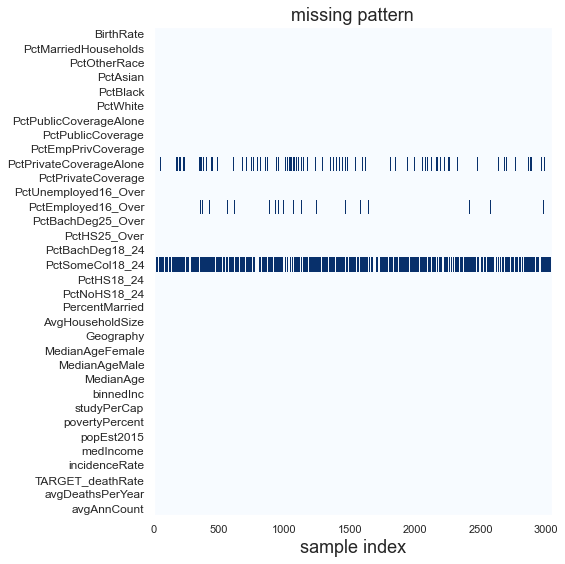

In [18]:
%%time
import bpca_impute.bpca_impute_util as util
_,_ = util.show_missing_pattern_binary(df_data,figsize=(8,8))

### Spliting dataset into training and test

In [19]:
# Spliting the data into training and test
from sklearn.model_selection import train_test_split
y = df_data.TARGET_deathRate
X = df_data.drop(['TARGET_deathRate'], axis=1).\
    select_dtypes(exclude=['object'])
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

### Standardization of the data matrix


In general, most of teh data imputation methods leverage the relationship between the variables to infer the value of missing entries. In inferring the relationship, the relative scale of the variables matters very much. So, **whenever possible, it is strongly recommended to standardize the data matrix before applying data imputation methods.**

Numpy's `np.nanmean()` and `np.nanstd()` come in handy for standardization of data matrices with missing entries.

In [20]:
import numpy as np
vnames = X_train.columns
Xtr = X_train.to_numpy().T
m0 = np.nanmean(Xtr,axis=1).reshape(-1,1)
std0 = np.nanstd(Xtr,axis=1).reshape(-1,1)

Xtr = (Xtr - m0)/std0    
Xte = X_test.to_numpy().T
Xte = (Xte - m0)/std0   

### Imputing training data matrix

Now let us get a imputed version of the data matrix. Note that `bpca_impute` uses the column-based data format, where samples are stored in the columns, not rows. 


In [21]:
import bpca_impute.bpca_impute as bpca    
Xtr_filled,param = bpca.impute_bpca_ard(Xtr)

W = param.get('W')
Adiag = param.get('Adiag')
mu = param.get('mu')

#samples=2437, obs.dim=31, initial latent dim=30
  50: err_L=0.03682, err_x=0.02722
 100: err_L=0.00173, err_x=0.00549
 150: err_L=0.00103, err_x=0.00383
 200: err_L=0.00059, err_x=0.00259
 250: err_L=0.00038, err_x=0.00187
 300: err_L=0.00027, err_x=0.00143
 350: err_L=0.00021, err_x=0.00115
 400: err_L=0.00017, err_x=0.00095
 450: err_L=0.00014, err_x=0.00080
 500: err_L=0.00012, err_x=0.00069
Finished ARD_BPCA:itr=500, err_L=0.00012132951469058195, err_x=0.0006893698199007276


### 'Transferring' the learnings to test data

Here we consider a bit extreme case: We have only one test sample containing missing entries as shown below. We want to impute the missing entry using `bpca.impute_transfer()`. 

One important note here is that, due to the nature of the algorithm, `mu` must be provided if any of the variables in the test dataset is all nan. This is actually the case here. So,
```python
import bpca_impute.bpca_impute as bpca
Xte_imputed, param2 = bpca.impute_transfer(xsingle, W, mu=None)
```
will produce a "ValueError: mu cannot be None when N(#samples)=1".


In [22]:
# Picking a single sample 
xsingle = Xte[:,0] # this is 1D vector
pd.Series(xsingle,vnames)

avgAnnCount               -0.455781
avgDeathsPerYear          -0.396331
incidenceRate             -0.821846
medIncome                 -0.096754
popEst2015                -0.348993
povertyPercent            -1.058044
studyPerCap               -0.284021
MedianAge                  0.050788
MedianAgeMale              1.241373
MedianAgeFemale            1.442579
AvgHouseholdSize          -0.816912
PercentMarried             2.172731
PctNoHS18_24              -0.927322
PctHS18_24                 0.378930
PctSomeCol18_24                 NaN
PctBachDeg18_24            0.544681
PctHS25_Over               0.039569
PctBachDeg25_Over          0.903616
PctEmployed16_Over         1.294367
PctUnemployed16_Over      -1.952125
PctPrivateCoverage         1.382832
PctPrivateCoverageAlone    0.838112
PctEmpPrivCoverage         0.051838
PctPublicCoverage         -0.574103
PctPublicCoverageAlone    -1.323775
PctWhite                   0.589695
PctBlack                  -0.538843
PctAsian                  -0

In [23]:
# performing transfer
import bpca_impute.bpca_impute as bpca
Xte_imputed, param2 = bpca.impute_transfer(xsingle, W, mu=mu)

 100: err_L=0.00039, err_x=0.00698
 200: err_L=0.00010, err_x=0.00234
 300: err_L=0.00002, err_x=0.00101
 400: err_L=0.00001, err_x=0.00048
 500: err_L=0.00000, err_x=0.00023
 600: err_L=0.00000, err_x=0.00012
Finished EM_PCA transfer itr=621,err_L=3.007040099384293e-07,err_x=9.93876494327723e-05


### Mapping back to the original scale

Here is a comparison between the imputed sample and the original.

In [24]:
Xte_imp_ = (Xte_imputed*std0) + m0
pd.Series(Xte_imp_.ravel(),vnames)

avgAnnCount                   17.000000
avgDeathsPerYear               6.000000
incidenceRate                405.200000
medIncome                  45710.000000
popEst2015                  2359.000000
povertyPercent                10.200000
studyPerCap                    0.000000
MedianAge                     47.600000
MedianAgeMale                 46.100000
MedianAgeFemale               49.800000
AvgHouseholdSize               2.140000
PercentMarried                66.700000
PctNoHS18_24                  10.800000
PctHS18_24                    38.400000
PctSomeCol18_24               35.505979
PctBachDeg18_24                8.600000
PctHS25_Over                  35.100000
PctBachDeg25_Over             18.100000
PctEmployed16_Over            64.700000
PctUnemployed16_Over           1.200000
PctPrivateCoverage            78.800000
PctPrivateCoverageAlone       56.700000
PctEmpPrivCoverage            41.600000
PctPublicCoverage             31.900000
PctPublicCoverageAlone        11.300000


In [25]:
X_test.iloc[0,:]

avgAnnCount                   17.000000
avgDeathsPerYear               6.000000
incidenceRate                405.200000
medIncome                  45710.000000
popEst2015                  2359.000000
povertyPercent                10.200000
studyPerCap                    0.000000
MedianAge                     47.600000
MedianAgeMale                 46.100000
MedianAgeFemale               49.800000
AvgHouseholdSize               2.140000
PercentMarried                66.700000
PctNoHS18_24                  10.800000
PctHS18_24                    38.400000
PctSomeCol18_24                     NaN
PctBachDeg18_24                8.600000
PctHS25_Over                  35.100000
PctBachDeg25_Over             18.100000
PctEmployed16_Over            64.700000
PctUnemployed16_Over           1.200000
PctPrivateCoverage            78.800000
PctPrivateCoverageAlone       56.700000
PctEmpPrivCoverage            41.600000
PctPublicCoverage             31.900000
PctPublicCoverageAlone        11.300000
